First we import the necessary packages: `cvxpy` for solving optimization problems, `numpy` for linear algebra and `matplotlib` for using the `stairs()` function to graph the signal.

In [1]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt

\

Next we enter the data required to form the optimization problem, namely $A, b, x_{\text{des}}, N$.

In [2]:
A = np.matrix([[-1, 0.4, 0.8],[1, 0, 0],[0, 1, 0]])
b = [1, 0, 0.3]
x_des = [7, 2, -6]
N = 30



The original optimization problem is $$\begin{aligned}
\min_{u} &\sum_{i=0}^{N-1} f(u(i))\\
\text{s.t. } 
&M u = x_{\text{des}}
\end{aligned}$$
where $$M=\begin{bmatrix}A^{N-1}b & A^{N-2}b & \cdots & Ab & b\end{bmatrix}.$$
In the next chunk of code, we compute $M$ by iteratively acting $A$ on $b$ and pushing them as columns of $M$.\

We also initialize a list `c = [1,1,...,1]` which essentially does the job of an $N\times 1$ column vector comprising all $1$'s.

In [3]:
M = []
temp = np.matrix([[1,0,0],[0,1,0],[0,0,1]])
for i in range(N):
    M.insert(0, (temp @ b).tolist()[0])
    temp = A * temp
M = np.matrix(M).T

c = [1] * N

\

Now we want to focus on the function $f(a) = \begin{cases}|a| &\text{if } |a|\le 1\\2|a|-1 &\text{otherwise}\end{cases}$. It is easy to see that this expression is exactly $\max\left(|a|, 2|a|-1\right)$. So each summand in the abovementioned objective is precisely $\max\left(|u(i)|, 2|u(i)|-1\right)$. This is the expression `f` (so `f[i] = max(abs(u[i]), abs(2u[i])-1)`) in the following block of code. The objective `obj` is simply the sum of `f[i]`'s and the only constraint `cons` is $M u = x_{\text{des}}$.

In [4]:
u = cp.Variable(N, 'u')
f = cp.maximum(cp.abs(u), cp.abs(u+u)-c)
obj = cp.sum(f)
cons = [M @ u == x_des]
problem = cp.Problem(cp.Minimize(obj), cons)
problem.solve(verbose = True, solver = cp.ECOS)

                                     CVXPY                                     
                                     v1.4.2                                    
(CVXPY) Feb 24 04:11:56 PM: Your problem has 30 variables, 1 constraints, and 0 parameters.
(CVXPY) Feb 24 04:11:56 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Feb 24 04:11:56 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Feb 24 04:11:56 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Feb 24 04:11:56 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Feb 24 04:11:56 PM: Compiling problem (target solver=ECOS).
(CVX

17.32356785630167

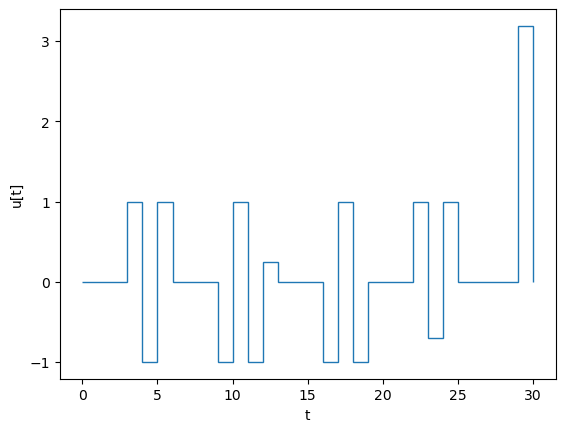

In [5]:
plt.stairs(u.value, range(N+1))
plt.xlabel('t')
plt.ylabel('u[t]')
plt.show()

\

The above solution was based on directly solving the optimization problem, without writing it as an LP. We now solve the following LP which is mentioned in my solution: $$\begin{aligned}
\min_{q,v,w} &\sum_{i=0}^{N-1} w(i)\\
\text{s.t. } 
&M q = x_{\text{des}}\\
&-v+q\le 0\\
&-v-q\le 0\\
&-w+v\le 0\\
&2v-\pmb c -w\le 0.
\end{aligned}$$

Note that the variable $u$ has been replaced with $q$ because we used $u$ above.

In [6]:
q = cp.Variable(N, 'q')
v = cp.Variable(N, 'v')
w = cp.Variable(N, 'w')
ob = cp.sum(w)
con = [M @ q == x_des, q - v <= 0, q + v >= 0, v - w <= 0, v + v - c - w <= 0]
pb = cp.Problem(cp.Minimize(ob), con)
pb.solve(verbose = True, solver = cp.ECOS)

                                     CVXPY                                     
                                     v1.4.2                                    
(CVXPY) Feb 24 04:11:56 PM: Your problem has 90 variables, 5 constraints, and 0 parameters.
(CVXPY) Feb 24 04:11:56 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Feb 24 04:11:56 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Feb 24 04:11:56 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Feb 24 04:11:56 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Feb 24 04:11:56 PM: Compiling problem (target solver=ECOS).
(CVX

17.323567854988987

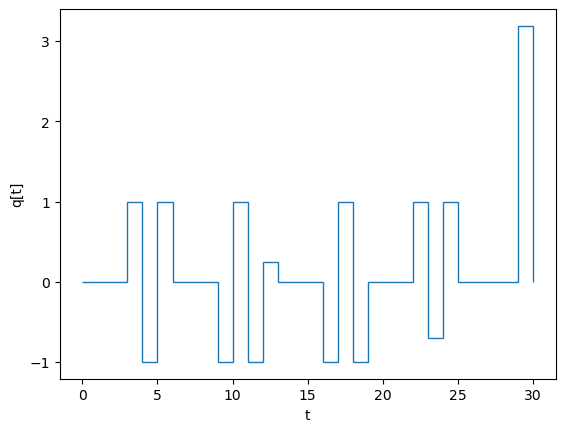

In [7]:
plt.stairs(q.value,range(N+1))
plt.xlabel('t')
plt.ylabel('q[t]')
plt.show()

\

The LP formulation indeed gives the same solution as the original formulation. The following line determines the $\ell_1$ error between the optimal solutions of the above two problems, which is $<10^{-8}$, so the solutions are practically the same. 

In [8]:
print(sum([abs(q.value[i] - u.value[i]) for i in range(N)]))

7.965044064222433e-09
